In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import necessary libraries
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
import seaborn as sns
import pandas as pd
import numpy as np

In [ ]:
# extract zip file
import zipfile
import os

# Path to your ZIP file in Google Drive
zip_path = '/content/drive/MyDrive/Pest_Detection_Project/pest_dataset.zip'  # Adjust the path if needed
extract_path = '/content/dataset'  # Folder where we want to extract the dataset

# Unzipping the dataset
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Verify the extracted contents
os.listdir(extract_path)  # This should show 'train' and 'test' directories

['test.txt', 'classes.txt', 'val.txt', 'train.txt', 'classification']

In [ ]:
# Load class labels
f = open('/content/dataset/classes.txt')
label = []
name = []
for line in f.readlines():
    label.append(int(line.split()[0]))
    name.append(' '.join(line.split()[1:]))
classes = pd.DataFrame([label, name]).T
classes.columns = ['label', 'name']

In [ ]:
# Load train, validation, and test data
train_df = pd.read_csv('/content/dataset/train.txt', sep=' ', header=None, engine='python')
train_df.columns = ['image_path', 'label']

test_df = pd.read_csv('/content/dataset/test.txt', sep=' ', header=None, engine='python')
test_df.columns = ['image_path', 'label']

val_df = pd.read_csv('/content/dataset/val.txt', sep=' ', header=None, engine='python')
val_df.columns = ['image_path', 'label']

In [ ]:


# Sets paths to where training, validation, and test images are stored.
TRAIN_DIR = '/content/dataset/classification/train'
VAL_DIR   = '/content/dataset/classification/val'
TEST_DIR  = '/content/dataset/classification/test'

# Copy original DataFrames to avoid modifying them directly
train_df_img = train_df.copy().reset_index(drop=True)
val_df_img   = val_df.copy().reset_index(drop=True)
test_df_img  = test_df.copy().reset_index(drop=True)

#Creates full image file paths by combining folder path, label folder, and image filename.
train_df_img['image_fullpath'] = TRAIN_DIR + "/" + train_df_img['label'].astype(str) + "/" + train_df_img['image_path']
val_df_img['image_fullpath']   = VAL_DIR + "/" + val_df_img['label'].astype(str)   + "/" + val_df_img['image_path']
test_df_img['image_fullpath']  = TEST_DIR + "/" + test_df_img['label'].astype(str) + "/" + test_df_img['image_path']

#Converts labels to strings, so they can be used correctly with Keras for classification.
train_df_img['label'] = train_df_img['label'].astype(str)
val_df_img['label']   = val_df_img['label'].astype(str)
test_df_img['label']  = test_df_img['label'].astype(str)

<ipython-input-7-d7bfdd59dd01>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="name", y="count", data=merged_df, alpha=0.8, palette='rocket')


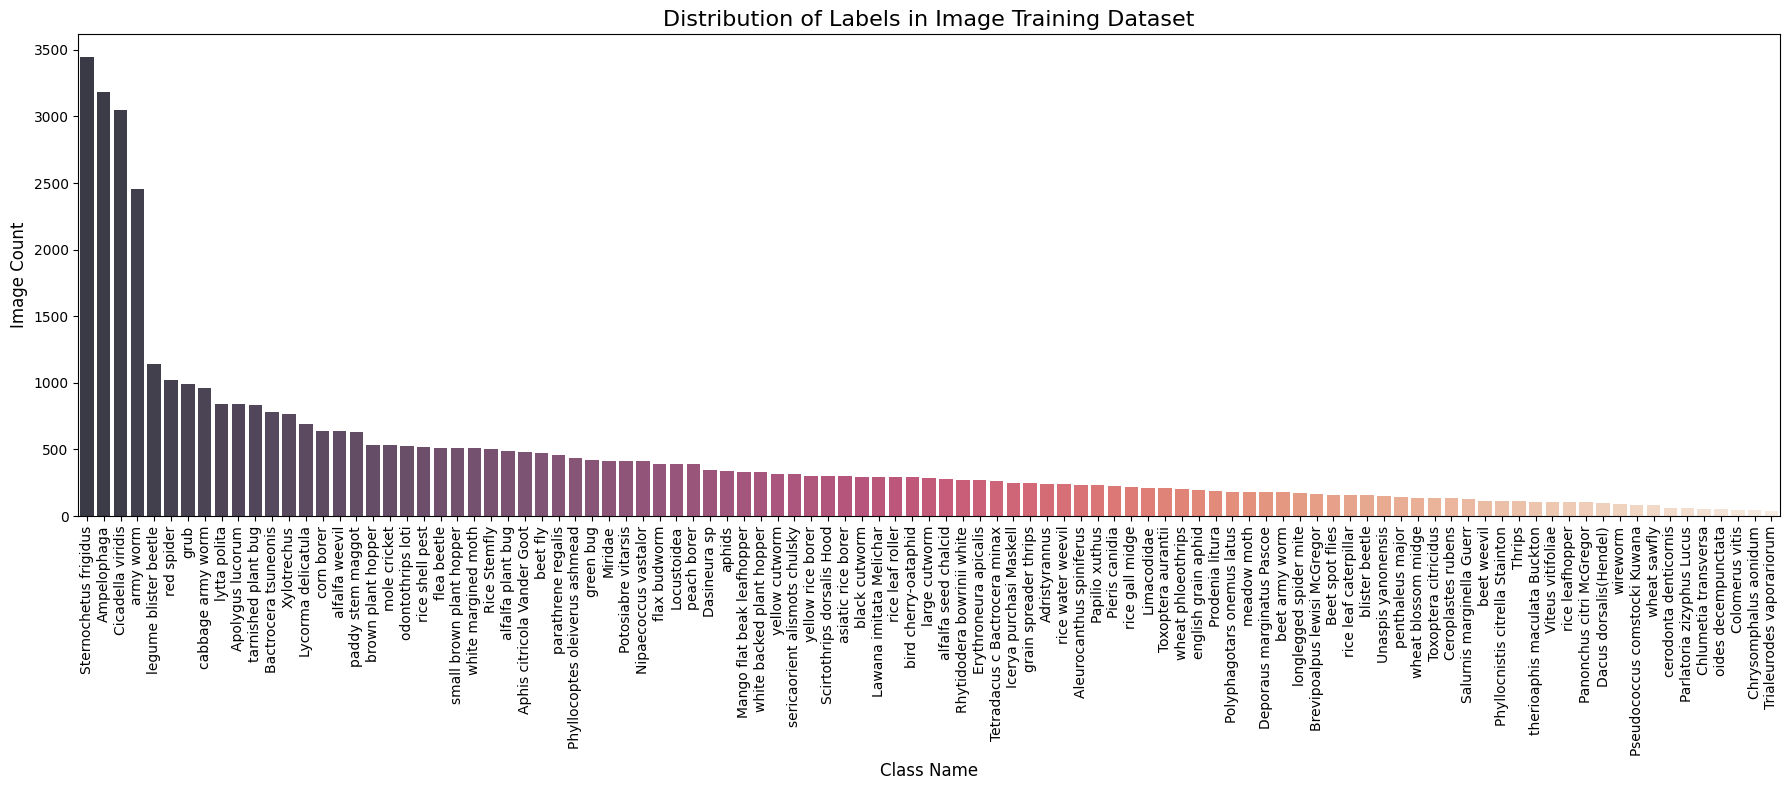

In [ ]:
# Display label distribution

train_df_img['label'] = train_df_img['label'].astype(str)
classes['label'] = classes['label'].astype(str)

# Count the number of images per label
label_counts = train_df_img['label'].value_counts().reset_index()
label_counts.columns = ['label', 'count']

# Merge counts with class names
merged_df = pd.merge(label_counts, classes, on='label', how='left')

# Plot
plt.figure(figsize=(18, 8))
sns.barplot(x="name", y="count", data=merged_df, alpha=0.8, palette='rocket')
plt.title('Distribution of Labels in Image Training Dataset', fontsize=16)
plt.xlabel('Class Name', fontsize=12)
plt.ylabel('Image Count', fontsize=12)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
# Parameters
IMAGE_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 50
NUM_CLASSES = classes['label'].nunique()  # Now 102


In [ ]:

# Create data generators for training, validation, and test sets
train_datagen = ImageDataGenerator(
    rescale = 1/255,
    width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    zoom_range=[.8, 1],
    channel_shift_range=30,
    fill_mode='reflect')

test_datagen = ImageDataGenerator(rescale = 1/255)

test_gen = test_datagen.flow_from_dataframe(
    dataframe=test_df_img,
    x_col='image_fullpath',
    y_col='label',
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='training'

)

train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df_img,
    x_col='image_fullpath',
    y_col='label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='training'
)

valid_datagen = ImageDataGenerator(rescale = 1/255)

valid_gen= valid_datagen.flow_from_dataframe(
    dataframe=val_df_img,
    x_col='image_fullpath',
    y_col='label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)
print(f"Training set: {train_gen.n} images belonging to {len(train_gen.class_indices)} classes.")
print(f"Validation set: {valid_gen.n} images belonging to {len(valid_gen.class_indices)} classes.")
print(f"Test set: {test_gen.n} images belonging to {len(test_gen.class_indices)} classes.")
STEP_SIZE_TRAIN = train_gen.n // train_gen.batch_size
STEP_SIZE_VALID = valid_gen.n // valid_gen.batch_size
#This calculates the number of batches per epoch during training and validation.




Found 22619 validated image filenames belonging to 102 classes.
Found 45095 validated image filenames belonging to 102 classes.
Found 7508 validated image filenames belonging to 102 classes.
Training set: 45095 images belonging to 102 classes.
Validation set: 7508 images belonging to 102 classes.
Test set: 22619 images belonging to 102 classes.


In [ ]:
# Define the ResNet model
input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
base_model = ResNet50(include_top=False, input_tensor=input_tensor, weights='imagenet')

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
#checkpoint = ModelCheckpoint('resnet50_best_model.keras', monitor='val_loss', save_best_only=True, mode='min')
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
early_stopping_callbacks = tf.keras.callbacks.EarlyStopping(patience = 15, restore_best_weights = True, verbose = 1)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# Train the model
history = model.fit(
    train_gen,
    steps_per_epoch=STEP_SIZE_TRAIN,
    epochs=EPOCHS,
    validation_data=valid_gen,
    validation_steps=STEP_SIZE_VALID,
    callbacks=[early_stopping_callbacks]
)


Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  1/560 ━━━━━━━━━━━━━━━━━━━━ 11:02:53 71s/step - accuracy: 0.0625 - loss: 2.7219

I0000 00:00:1733067033.459833      71 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


560/560 ━━━━━━━━━━━━━━━━━━━━ 410s 606ms/step - accuracy: 0.5740 - loss: 1.3001 - val_accuracy: 0.2608 - val_loss: 2.2618
Epoch 2/50
  1/560 ━━━━━━━━━━━━━━━━━━━━ 1:26 154ms/step - accuracy: 0.8125 - loss: 0.9109

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


560/560 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8125 - loss: 0.9109 - val_accuracy: 0.2500 - val_loss: 1.5590
Epoch 3/50
560/560 ━━━━━━━━━━━━━━━━━━━━ 229s 404ms/step - accuracy: 0.7937 - loss: 0.6533 - val_accuracy: 0.7688 - val_loss: 0.7177
Epoch 4/50
560/560 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step - accuracy: 0.8750 - loss: 0.3514 - val_accuracy: 0.8750 - val_loss: 0.3311
Epoch 5/50
560/560 ━━━━━━━━━━━━━━━━━━━━ 228s 402ms/step - accuracy: 0.8426 - loss: 0.4958 - val_accuracy: 0.7866 - val_loss: 0.6988
Epoch 6/50
560/560 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step - accuracy: 0.9062 - loss: 0.3908 - val_accuracy: 1.0000 - val_loss: 0.1626
Epoch 7/50
560/560 ━━━━━━━━━━━━━━━━━━━━ 228s 401ms/step - accuracy: 0.8623 - loss: 0.4292 - val_accuracy: 0.8038 - val_loss: 0.6377
Epoch 8/50
560/560 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/step - accuracy: 0.8438 - loss: 0.3465 - val_accuracy: 1.0000 - val_loss: 0.0265
Epoch 9/50
560/560 ━━━━━━━━━━━━━━━━━━━━ 227s 401ms/step - accuracy: 0.8809 - loss: 0.3718 - val_a

In [ ]:
# Evaluate the model(Correction Test accuracy)
loss, accuracy = model.evaluate(test_gen)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")

281/281 ━━━━━━━━━━━━━━━━━━━━ 74s 264ms/step - accuracy: 0.8230 - loss: 0.7521
Test accuracy: 82.91%


In [ ]:
# Save the model
model.save('resnet50_model.h5')  # Save the entire model to a file
print("Model saved as 'resnet50_model.h5'")


Model saved as 'resnet50_model.h5'
